# The list of (not so) childish ideas to improve performance of GANs

In the last exercise we had a working GAN on MNIST and changed the code such, that we negatively influenced the training stability of GANs and induced e.g. mode collapse.

For this exercise, we go the other way round: We continue with Ex B. e) and try to get the code that ran well on MNIST to generate natural images from [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). 

Here is a **List of (not so) childish ideas** and things one could try out to get his code to run. You might notice that some of the ideas are sensible, while other ideas are not very useful. 
1. Replace line 99 `X_train = X_train.astype('float32') / 255.0` with `X_train = X_train / 127.5 - 1`.
2. Enlarge the number of “epochs” (actually iterations) from 30k to 100k.
3. Decrease the batch size.
4. Enlarge the number of neurons in each Dense layer.
5. Visualise the generated samples and print the loss less often.
6. Line 123: remove the 0.5 multiplication
7. Enlarge the latent dimension, see `self.latent_dim` (line 23).
8. Adjust the Adam learning rate (line 25).
9. Set in line 41 the discriminator trainability to True.
10. Remove the batch normalization lines (58, 61, 64).
11. Add Dropout
12. Change the `binary_crossentropy` loss to the L2 loss
13. Add more layers for a deeper network
14. Exchange the dence layers with convolutional ones.

**Task:** Classify the items from the list above, establishing whether implementing these ideas would

  a) Improve the quality of the generated samples. 

  b) Diminish the quality of the generated samples.

  c) Have a low impact where it is unclear if it would improve the quality of the generated samples or not.

Some ideas can be ruled out or motivated by theoretical considerations, others are hard to decide upon without running the code. Running or not running the code is again optional (consider running it on the cluster). In either case, **always discuss and motivate your answer**: what does the change influence and what would you expect from it? If you are undecided, comment and debate (pro and contra). Hint: If you run the code, you always have the Machine Learning “Totschlagargument”: “but it works!” ;)

This exercise was focused on getting this example to work on CIFAR10 with code changes of max 2 lines. Please consult [these ganhacks](https://github.com/soumith/ganhacks) for more general tips.

## Original source code

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images-orig

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images-orig/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.756670, acc.: 10.94%] [G loss: 0.751934]
25002 [D loss: 0.745409, acc.: 7.81%] [G loss: 0.746353]
25003 [D loss: 0.747342, acc.: 15.62%] [G loss: 0.744237]
25004 [D loss: 0.757564, acc.: 9.38%] [G loss: 0.746233]
25005 [D loss: 0.753978, acc.: 4.69%] [G loss: 0.751508]
25006 [D loss: 0.761975, acc.: 0.00%] [G loss: 0.732767]
25007 [D loss: 0.748375, acc.: 0.00%] [G loss: 0.745729]
25008 [D loss: 0.754535, acc.: 0.00%] [G loss: 0.743189]
25009 [D loss: 0.757949, acc.: 9.38%] [G loss: 0.742438]
25010 [D loss: 0.756543, acc.: 0.00%] [G loss: 0.748420]
25011 [D loss: 0.760777, acc.: 0.00%] [G loss: 0.737242]
25012 [D loss: 0.757207, acc.: 0.00%] [G loss: 0.755335]
25013 [D loss: 0.757026, acc.: 3.12%] [G loss: 0.767223]
25014 [D loss: 0.758910, acc.: 0.00%] [G loss: 0.755638]
25015 [D loss: 0.756967, acc.: 1.56%] [G loss: 0.744564]
25016 [D loss: 0.762624, acc.: 1.56%] [G loss: 0.748475]
25017 [D loss: 0.75

## Case 1
### Replace line 99 `X_train = X_train.astype('float32') / 255.0` with `X_train = X_train / 127.5 - 1`

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images-1

class GAN1():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input to range [-1.,1.]
        X_train = X_train / 127.5 - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images-1/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan1 = GAN1()
    with tf.device(tf.test.gpu_device_name()):
      gan1.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.746051, acc.: 46.88%] [G loss: 0.643759]
25002 [D loss: 0.753544, acc.: 42.19%] [G loss: 0.711436]
25003 [D loss: 0.699114, acc.: 46.88%] [G loss: 0.662849]
25004 [D loss: 0.766747, acc.: 40.62%] [G loss: 0.669621]
25005 [D loss: 0.731992, acc.: 43.75%] [G loss: 0.644721]
25006 [D loss: 0.737332, acc.: 48.44%] [G loss: 0.702216]
25007 [D loss: 0.717668, acc.: 46.88%] [G loss: 0.689788]
25008 [D loss: 0.708221, acc.: 51.56%] [G loss: 0.687428]
25009 [D loss: 0.721543, acc.: 42.19%] [G loss: 0.677562]
25010 [D loss: 0.716507, acc.: 54.69%] [G loss: 0.687738]
25011 [D loss: 0.703919, acc.: 46.88%] [G loss: 0.660918]
25012 [D loss: 0.755565, acc.: 43.75%] [G loss: 0.708021]
25013 [D loss: 0.696509, acc.: 54.69%] [G loss: 0.664669]
25014 [D loss: 0.713227, acc.: 45.31%] [G loss: 0.684645]
25015 [D loss: 0.720894, acc.: 53.12%] [G loss: 0.695480]
25016 [D loss: 0.689543, acc.: 50.00%] [G loss: 0.667675]
25017

## Case 3
### Decrease the batch size ($32 \longrightarrow 16$)

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images-3

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images-3/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan3 = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan3.train(epochs=30000, batch_size=16, sample_interval=200, generator_more_often=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.727352, acc.: 34.38%] [G loss: 0.706473]
25002 [D loss: 0.783014, acc.: 25.00%] [G loss: 0.699055]
25003 [D loss: 0.747005, acc.: 25.00%] [G loss: 0.725046]
25004 [D loss: 0.740091, acc.: 28.12%] [G loss: 0.735399]
25005 [D loss: 0.733773, acc.: 21.88%] [G loss: 0.738373]
25006 [D loss: 0.754294, acc.: 28.12%] [G loss: 0.746192]
25007 [D loss: 0.769015, acc.: 25.00%] [G loss: 0.773137]
25008 [D loss: 0.793252, acc.: 3.12%] [G loss: 0.757841]
25009 [D loss: 0.739639, acc.: 28.12%] [G loss: 0.746894]
25010 [D loss: 0.753343, acc.: 15.62%] [G loss: 0.748914]
25011 [D loss: 0.732719, acc.: 21.88%] [G loss: 0.753114]
25012 [D loss: 0.742284, acc.: 28.12%] [G loss: 0.717275]
25013 [D loss: 0.748768, acc.: 21.88%] [G loss: 0.727579]
25014 [D loss: 0.761945, acc.: 18.75%] [G loss: 0.729789]
25015 [D loss: 0.733968, acc.: 25.00%] [G loss: 0.731245]
25016 [D loss: 0.756637, acc.: 9.38%] [G loss: 0.725389]
25017 [

## Case 4
### Enlarge the number of neurons in each Dense layer (double the number in each Dense layer, except output layers in both discriminator and generator models)

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images-4

class GAN4():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images-4/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN4()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 513       
Total params: 3,672,065
Trainable params: 3,672,065
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.723271, acc.: 3.12%] [G loss: 0.690904]
25002 [D loss: 0.721069, acc.: 29.69%] [G loss: 0.690823]
25003 [D loss: 0.719673, acc.: 18.75%] [G loss: 0.701970]
25004 [D loss: 0.722298, acc.: 0.00%] [G loss: 0.701130]
25005 [D loss: 0.720234, acc.: 4.69%] [G loss: 0.700296]
25006 [D loss: 0.718899, acc.: 7.81%] [G loss: 0.705991]
25007 [D loss: 0.720942, acc.: 0.00%] [G loss: 0.704679]
25008 [D loss: 0.716759, acc.: 3.12%] [G loss: 0.713731]
25009 [D loss: 0.717959, acc.: 0.00%] [G loss: 0.718022]
25010 [D loss: 0.717999, acc.: 0.00%] [G loss: 0.717230]
25011 [D loss: 0.718840, acc.: 0.00%] [G loss: 0.720279]
25012 [D loss: 0.722182, acc.: 1.56%] [G loss: 0.708812]
25013 [D loss: 0.720734, acc.: 0.00%] [G loss: 0.699590]
25014 [D loss: 0.721281, acc.: 4.69%] [G loss: 0.695046]
25015 [D loss: 0.721652, acc.: 15.62%] [G loss: 0.690736]
25016 [D loss: 0.716998, acc.: 26.56%] [G loss: 0.693069]
25017 [D loss: 0.

## Case 6
### Line 123: remove the 0.5 multiplication

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_6

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_6/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

mkdir: cannot create directory ‘images_6’: File exists
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainabl

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 1.527217, acc.: 46.88%] [G loss: 0.780181]
25002 [D loss: 1.547988, acc.: 21.88%] [G loss: 0.765426]
25003 [D loss: 1.510735, acc.: 15.62%] [G loss: 0.752704]
25004 [D loss: 1.513329, acc.: 21.88%] [G loss: 0.749005]
25005 [D loss: 1.476042, acc.: 12.50%] [G loss: 0.737347]
25006 [D loss: 1.484553, acc.: 25.00%] [G loss: 0.753156]
25007 [D loss: 1.527609, acc.: 40.62%] [G loss: 0.761079]
25008 [D loss: 1.498096, acc.: 50.00%] [G loss: 0.751716]
25009 [D loss: 1.512926, acc.: 53.12%] [G loss: 0.735367]
25010 [D loss: 1.495006, acc.: 34.38%] [G loss: 0.765939]
25011 [D loss: 1.469781, acc.: 46.88%] [G loss: 0.764388]
25012 [D loss: 1.533011, acc.: 18.75%] [G loss: 0.774662]
25013 [D loss: 1.501471, acc.: 31.25%] [G loss: 0.767752]
25014 [D loss: 1.523216, acc.: 25.00%] [G loss: 0.777633]
25015 [D loss: 1.511630, acc.: 6.25%] [G loss: 0.774544]
25016 [D loss: 1.496764, acc.: 3.12%] [G loss: 0.788951]
25017 [

## Case 7
### Enlarge the latent dimension, see `self.latent_dim` (line 23) from $100$ to $200$

In [ ]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_7

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 200

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_7/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.752344, acc.: 21.88%] [G loss: 0.751184]
25002 [D loss: 0.757763, acc.: 20.31%] [G loss: 0.738457]
25003 [D loss: 0.735148, acc.: 25.00%] [G loss: 0.737436]
25004 [D loss: 0.761393, acc.: 15.62%] [G loss: 0.748549]
25005 [D loss: 0.764036, acc.: 14.06%] [G loss: 0.754310]
25006 [D loss: 0.749074, acc.: 18.75%] [G loss: 0.751428]
25007 [D loss: 0.760428, acc.: 14.06%] [G loss: 0.739634]
25008 [D loss: 0.749620, acc.: 18.75%] [G loss: 0.739239]
25009 [D loss: 0.745697, acc.: 17.19%] [G loss: 0.761806]
25010 [D loss: 0.765840, acc.: 14.06%] [G loss: 0.754053]
25011 [D loss: 0.744630, acc.: 18.75%] [G loss: 0.735016]
25012 [D loss: 0.773378, acc.: 12.50%] [G loss: 0.739859]
25013 [D loss: 0.749618, acc.: 18.75%] [G loss: 0.762421]
25014 [D loss: 0.748520, acc.: 15.62%] [G loss: 0.739900]
25015 [D loss: 0.758892, acc.: 14.06%] [G loss: 0.744099]
25016 [D loss: 0.760298, acc.: 6.25%] [G loss: 0.758334]
25017 

##  Case 8
### Adjust the Adam learning rate (line 25) ($0.00001 \longrightarrow 0.001$)

In [4]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_8

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_8/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.686713, acc.: 59.38%] [G loss: 1.147703]
25002 [D loss: 0.490459, acc.: 75.00%] [G loss: 1.831949]
25003 [D loss: 0.598617, acc.: 60.94%] [G loss: 1.674939]
25004 [D loss: 0.624165, acc.: 65.62%] [G loss: 1.528681]
25005 [D loss: 0.644414, acc.: 53.12%] [G loss: 2.405068]
25006 [D loss: 0.986292, acc.: 37.50%] [G loss: 2.679936]
25007 [D loss: 1.039646, acc.: 26.56%] [G loss: 1.169967]
25008 [D loss: 0.686272, acc.: 57.81%] [G loss: 1.195277]
25009 [D loss: 0.577369, acc.: 75.00%] [G loss: 1.238042]
25010 [D loss: 0.556536, acc.: 68.75%] [G loss: 1.021053]
25011 [D loss: 0.648679, acc.: 62.50%] [G loss: 1.113606]
25012 [D loss: 0.603576, acc.: 70.31%] [G loss: 1.238271]
25013 [D loss: 0.671241, acc.: 54.69%] [G loss: 1.094973]
25014 [D loss: 0.755166, acc.: 46.88%] [G loss: 1.120142]
25015 [D loss: 0.704374, acc.: 50.00%] [G loss: 1.078940]
25016 [D loss: 0.645390, acc.: 56.25%] [G loss: 0.932625]
25017

## Case 9
### Set in line 41 the `discriminator trainability` to `True`

In [6]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_9

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = True

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_9/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.768180, acc.: 50.00%] [G loss: 0.463737]
25002 [D loss: 0.760342, acc.: 50.00%] [G loss: 0.472316]
25003 [D loss: 0.765818, acc.: 50.00%] [G loss: 0.466061]
25004 [D loss: 0.779441, acc.: 50.00%] [G loss: 0.463722]
25005 [D loss: 0.769624, acc.: 50.00%] [G loss: 0.465204]
25006 [D loss: 0.765205, acc.: 50.00%] [G loss: 0.464455]
25007 [D loss: 0.763796, acc.: 50.00%] [G loss: 0.463664]
25008 [D loss: 0.769821, acc.: 50.00%] [G loss: 0.471802]
25009 [D loss: 0.773606, acc.: 50.00%] [G loss: 0.469603]
25010 [D loss: 0.760010, acc.: 50.00%] [G loss: 0.468712]
25011 [D loss: 0.763060, acc.: 50.00%] [G loss: 0.467440]
25012 [D loss: 0.773222, acc.: 50.00%] [G loss: 0.463851]
25013 [D loss: 0.764590, acc.: 50.00%] [G loss: 0.461207]
25014 [D loss: 0.777095, acc.: 50.00%] [G loss: 0.463879]
25015 [D loss: 0.767123, acc.: 50.00%] [G loss: 0.467397]
25016 [D loss: 0.767029, acc.: 50.00%] [G loss: 0.473325]
25017

## Case 10
### Remove the batch normalization lines (58, 61, 64)

In [8]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_10

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_10/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.714432, acc.: 10.94%] [G loss: 0.691070]
25002 [D loss: 0.713930, acc.: 9.38%] [G loss: 0.687889]
25003 [D loss: 0.714142, acc.: 10.94%] [G loss: 0.688891]
25004 [D loss: 0.712949, acc.: 10.94%] [G loss: 0.688685]
25005 [D loss: 0.713903, acc.: 9.38%] [G loss: 0.691457]
25006 [D loss: 0.714172, acc.: 6.25%] [G loss: 0.690518]
25007 [D loss: 0.716622, acc.: 1.56%] [G loss: 0.689732]
25008 [D loss: 0.714136, acc.: 12.50%] [G loss: 0.688232]
25009 [D loss: 0.713975, acc.: 7.81%] [G loss: 0.684997]
25010 [D loss: 0.717164, acc.: 6.25%] [G loss: 0.683296]
25011 [D loss: 0.715384, acc.: 9.38%] [G loss: 0.683835]
25012 [D loss: 0.715096, acc.: 9.38%] [G loss: 0.681926]
25013 [D loss: 0.717060, acc.: 9.38%] [G loss: 0.683500]
25014 [D loss: 0.716668, acc.: 12.50%] [G loss: 0.685090]
25015 [D loss: 0.718053, acc.: 6.25%] [G loss: 0.686568]
25016 [D loss: 0.715909, acc.: 9.38%] [G loss: 0.685353]
25017 [D loss: 0

## Case 11
### Add Dropout

In [11]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_11

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.2))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.2))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_11/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.717716, acc.: 45.31%] [G loss: 0.814419]
25002 [D loss: 0.719811, acc.: 43.75%] [G loss: 0.784746]
25003 [D loss: 0.710021, acc.: 46.88%] [G loss: 0.806761]
25004 [D loss: 0.740375, acc.: 34.38%] [G loss: 0.801700]
25005 [D loss: 0.722400, acc.: 43.75%] [G loss: 0.815221]
25006 [D loss: 0.725146, acc.: 43.75%] [G loss: 0.841295]
25007 [D loss: 0.724287, acc.: 37.50%] [G loss: 0.842573]
25008 [D loss: 0.742837, acc.: 39.06%] [G loss: 0.826685]
25009 [D loss: 0.744423, acc.: 34.38%] [G loss: 0.844290]
25010 [D loss: 0.719655, acc.: 40.62%] [G loss: 0.794089]
25011 [D loss: 0.709956, acc.: 42.19%] [G loss: 0.859863]
25012 [D loss: 0.729816, acc.: 40.62%] [G loss: 0.824143]
25013 [D loss: 0.696191, acc.: 48.44%] [G loss: 0.854370]
25014 [D loss: 0.699774, acc.: 45.31%] [G loss: 0.773633]
25015 [D loss: 0.747483, acc.: 32.81%] [G loss: 0.872929]
25016 [D loss: 0.753917, acc.: 34.38%] [G loss: 0.850771]
25017

## Case 12
### Change the `binary_crossentropy` loss to the `L2` loss

In [13]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_12

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_12/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.269801, acc.: 18.75%] [G loss: 0.274742]
25002 [D loss: 0.266253, acc.: 28.12%] [G loss: 0.272557]
25003 [D loss: 0.267867, acc.: 37.50%] [G loss: 0.278488]
25004 [D loss: 0.267602, acc.: 32.81%] [G loss: 0.274682]
25005 [D loss: 0.265192, acc.: 34.38%] [G loss: 0.275555]
25006 [D loss: 0.266284, acc.: 29.69%] [G loss: 0.267736]
25007 [D loss: 0.266327, acc.: 23.44%] [G loss: 0.268657]
25008 [D loss: 0.267786, acc.: 26.56%] [G loss: 0.267771]
25009 [D loss: 0.265999, acc.: 21.88%] [G loss: 0.266739]
25010 [D loss: 0.268458, acc.: 14.06%] [G loss: 0.274011]
25011 [D loss: 0.265900, acc.: 28.12%] [G loss: 0.273348]
25012 [D loss: 0.268633, acc.: 23.44%] [G loss: 0.267593]
25013 [D loss: 0.264914, acc.: 37.50%] [G loss: 0.273142]
25014 [D loss: 0.270998, acc.: 34.38%] [G loss: 0.276457]
25015 [D loss: 0.268142, acc.: 26.56%] [G loss: 0.272755]
25016 [D loss: 0.264036, acc.: 32.81%] [G loss: 0.269605]
25017

## Case 13
### Add more layers for a deeper network, 2 layers more for the generator, and 1 more for the discriminator

In [16]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

!mkdir images_13

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.2))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, generator_more_often=1):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale input
        X_train = X_train.astype('float32') / 255.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            g_loss_total = 0.0
            for _ in range(generator_more_often):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                g_loss_total += g_loss

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss_total))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:, :]) #0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_13/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    with tf.device(tf.test.gpu_device_name()):
      gan.train(epochs=30000, batch_size=32, sample_interval=200, generator_more_often=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               262400    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 256)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
25001 [D loss: 0.783260, acc.: 0.00%] [G loss: 0.731400]
25002 [D loss: 0.796342, acc.: 0.00%] [G loss: 0.744534]
25003 [D loss: 0.782919, acc.: 3.12%] [G loss: 0.766049]
25004 [D loss: 0.793512, acc.: 0.00%] [G loss: 0.766385]
25005 [D loss: 0.775610, acc.: 1.56%] [G loss: 0.749888]
25006 [D loss: 0.783004, acc.: 0.00%] [G loss: 0.711216]
25007 [D loss: 0.800833, acc.: 1.56%] [G loss: 0.732057]
25008 [D loss: 0.783152, acc.: 1.56%] [G loss: 0.764372]
25009 [D loss: 0.780714, acc.: 3.12%] [G loss: 0.787249]
25010 [D loss: 0.791827, acc.: 7.81%] [G loss: 0.773743]
25011 [D loss: 0.802685, acc.: 3.12%] [G loss: 0.773867]
25012 [D loss: 0.786114, acc.: 3.12%] [G loss: 0.778273]
25013 [D loss: 0.778391, acc.: 9.38%] [G loss: 0.790990]
25014 [D loss: 0.793920, acc.: 6.25%] [G loss: 0.790573]
25015 [D loss: 0.796578, acc.: 1.56%] [G loss: 0.766868]
25016 [D loss: 0.787001, acc.: 0.00%] [G loss: 0.762409]
25017 [D loss: 0.8022

# Summary

|<img width=200/>**Change**|<img width=200/>**Expectations with discussion**| <img width=400/> **Original result** | <img width=400/>**Result** (at epoch 29800/or 99800 for idea 2)| <img width=200/> **Classification** (based on the results)|
|:----|:----|:------------:|:--------------:|:---|
|1. Replace line 99 `X_train = X_train.astype('float32') / 255.0` with `X_train = X_train / 127.5 - 1`.|Changing this line is to change the range of the features inside each data from range $[0.,1.]$ into $[-1., 1.]$. This is indeed data normalization. Based on the trained results from original source code, wider range means the features are separated more and become much more distinct for each data. Hope the representations will get better. |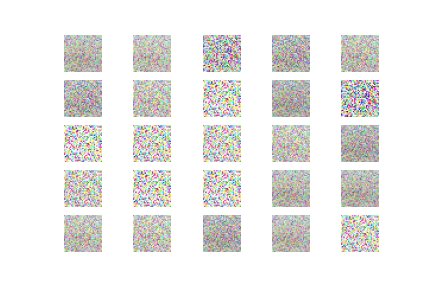 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|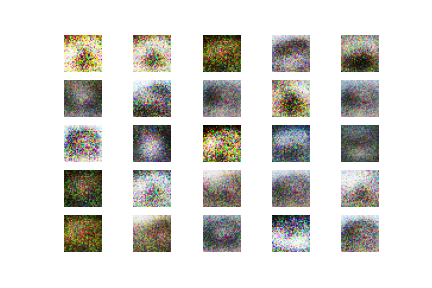 **<font color='red'>D loss: `0.709631`</font>, <font color='blue'>acc.: `48.44%`</font>, <font color='green'>G loss: `0.735589`</font>** |improve the quality of the generated samples|
|2. Enlarge the number of “epochs” (actually iterations) from 30k to 100k.| What I really see while training the original source code is that the losses in discriminator model keep decreasing to a limit and then increase again, while the losses in generator model keeps decreasing. And the discriminator accuracies keep becoming lower and lower. So I wonder what might be the case if we train more. However, as the generated data (faked ones) in the generator and the discriminator are trained with random inputs. There should be the time all types of features of data are learnt from both models. At this time the representations would be better for sure. I believe we can hope for better performance with this case. |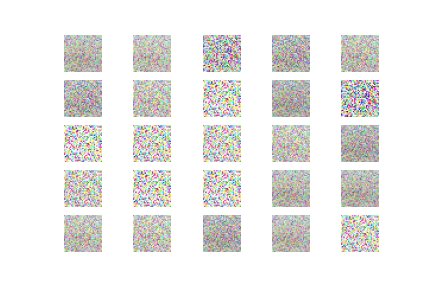 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|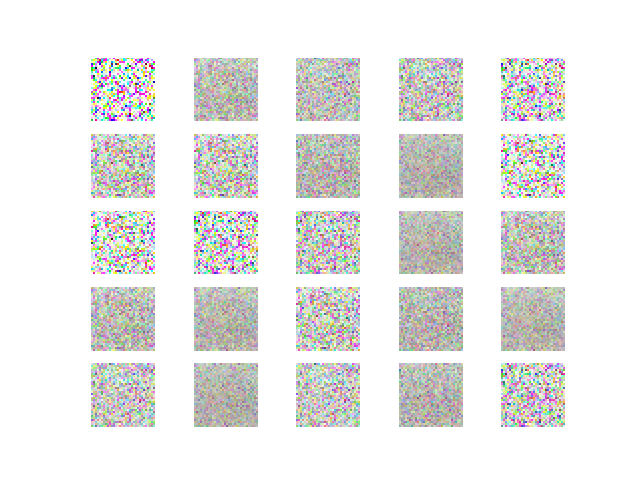 **<font color='red'>D loss: `0.702673`</font>, <font color='blue'>acc.: `21.88%`</font>, <font color='green'>G loss: `0.698610`</font>**|(doubtedly) have a low impact where it is unclear if it would improve the quality of the generated samples or not|
|3. Decrease the batch size (from $32$ to $16$).|This is, in my opinion, not really a good idea. We have the same time training for both models. The best way should be to let the 2 models learn more about the data instead of training less (smaller batch size, less learn). There's no way to ensure that the randomized with smaller batches would capture all the features like the original one. Even with `batch_size=32` we haven't obtained any positive results. So this will for sure be worse than the original one.|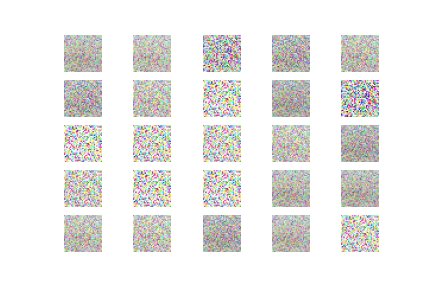 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**| 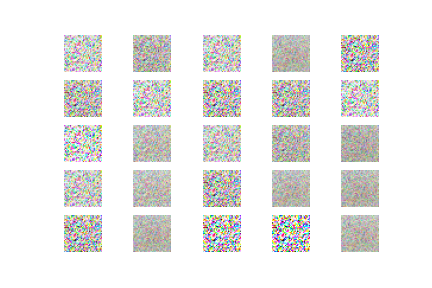 **<font color='red'>D loss: `0.729293`</font>, <font color='blue'>acc.: `37.50%`</font>, <font color='green'>G loss: `0.693201`</font>**| (seems to be sure) have a low impact where it is unclear if it would improve the quality of the generated samples or not|
|4. Enlarge the number of neurons in each Dense layer (double the number of neurons in each one).|More neurons in each Dense layer means the features are splitted more. Who can assure that which features should stay together, which one should be splitted? I believe choosing a wise number of neurons for each Dense layer is also a must. To be honest, I'd rather stay at the chosen numbers in the original source code. I guess the representations get worse with this case.|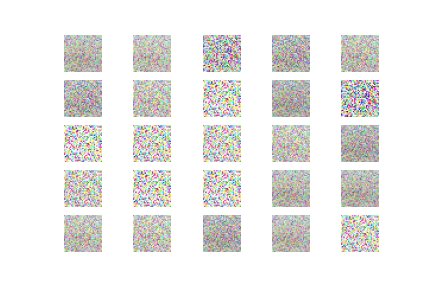 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|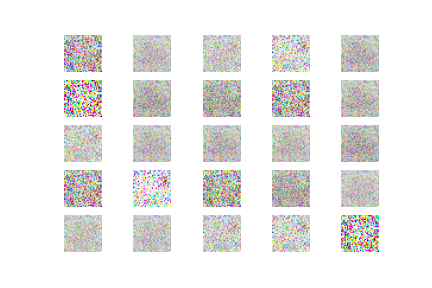 **<font color='red'>D loss: `0.724152`</font>, <font color='blue'>acc.: `14.06%`</font>, <font color='green'>G loss: `0.704026`</font>**| disminish the quality of the generated samples|
|5. Visualise the generated samples and print the loss less often.|I think there is not much to consider with this idea. Choosing when to visualize and when to print the loss doesn't make any changes at the data. So |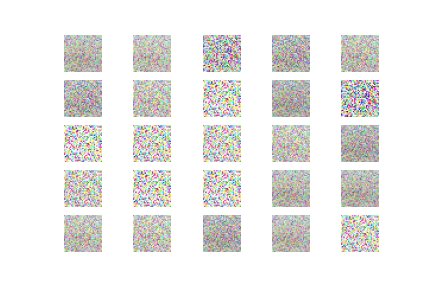 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**| same as original| Have a low impact where it is unclear if it would improve the quality of the generated samples or not|
|6. Line 123: remove the 0.5 multiplication|I guess this one has rarely any impact. In fact, the losses are reduced at a half, but only in term of the discriminator. And this doesn't make sense in training the input nor the hidden layers.|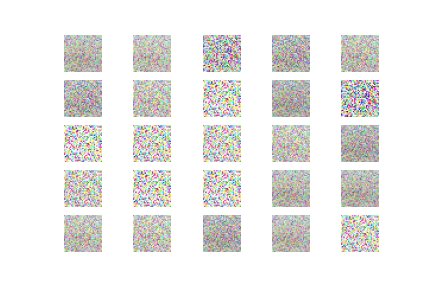 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|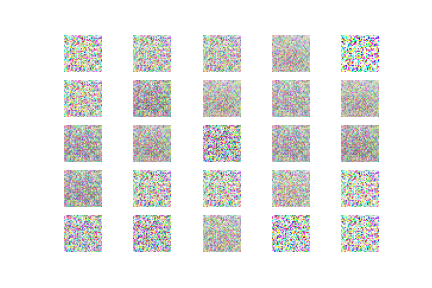 **<font color='red'>D loss: `1.502014`</font>, <font color='blue'>acc.: `37.50%`</font>, <font color='green'>G loss: `0.724038`</font>** | (probably) have a low impact where it is unclear if it would improve the quality of the generated samples or not|
|7. Enlarge the latent dimension, see `self.latent_dim` (line 23) to `200`.| Larger latent dimensions means more features of a data point to be under consideration for the generator to learn and fake a 'good' data. This is also similar to the case of **case 4**. We have to choose wisely how large this dimension should be. As least the features are not splitted as much as in case 4, so I think the representations could be better.|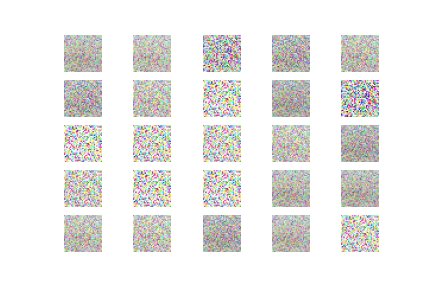 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|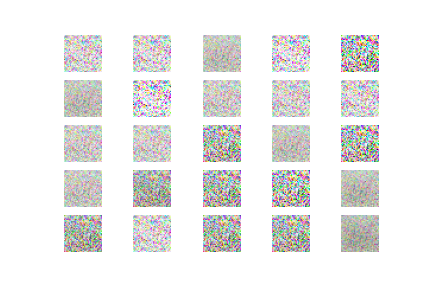 **<font color='red'>D loss: `0.746000`</font>, <font color='blue'>acc.: `20.31%`</font>, <font color='green'>G loss: `0.695980`</font>** |(slightly) disminish the quality of the generated samples|
|8. Adjust the Adam learning rate (line 25).|Normally, choosing a learning rate for the optimizer is also important. For sure this learning rate must be in range $(0,1)$. The default learning rate, in my view, is really small. So I try with an another one, $0.001$, which is normally used for SGD optimizer in most models that I once learnt and tried to train. So this choice is based more on my experiences. I believe it can result in better representations. |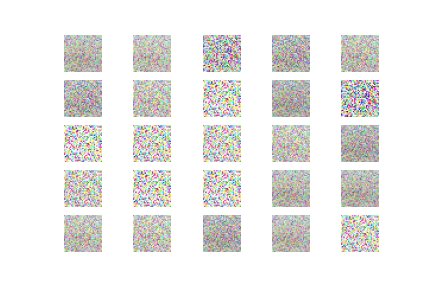 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|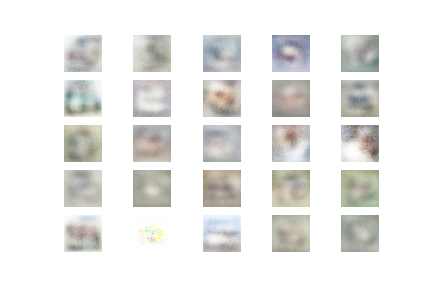 **<font color='red'>D loss: `0.623410`</font>, <font color='blue'>acc.: `62.50%`</font>, <font color='green'>G loss: `1.736980`</font>**|(definitely) improve the quality of the generated samples|
|9. Set in line 41 the discriminator trainability to True.|I have no idea what should be expected in this case. I thought the discriminator is always trained during times? Any result would make sense or make no sense.|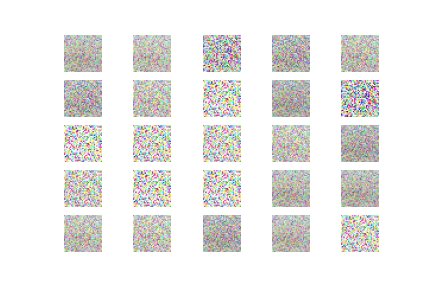 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|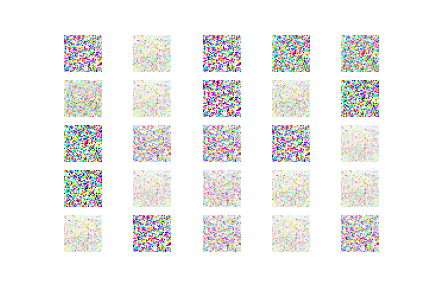 **<font color='red'>D loss: `0.752134`</font>, <font color='blue'>acc.: `50.00%`</font>, <font color='green'>G loss: `0.462791`</font>**|(doubtly) improve the quality of the generated samples|
|10. Remove the batch normalization lines (58, 61, 64).|It is really important during building networks to have normalization in each layer. When we remove all kinds of batch normalizations, there is no doubt that the results get worse.|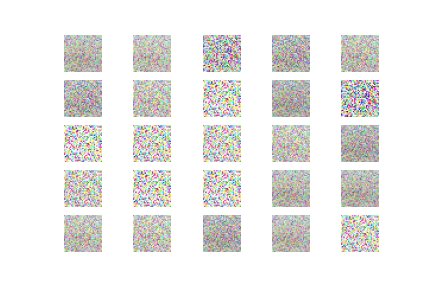 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|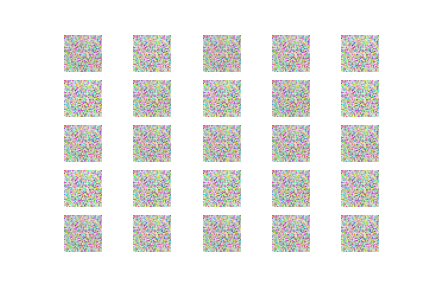 **<font color='red'>D loss: `0.691565`</font>, <font color='blue'>acc.: `31.25%`</font>, <font color='green'>G loss: `0.687907`</font>** |(probably) disminish the quality of the generated samples|
|11. Add Dropout|What I wonder is which neuron would be dropped out. Will that be the important ones or the noises. So the chances are 50-50. It's kind of hard to predict which way the result would go.|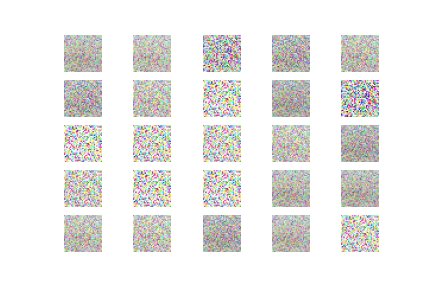 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|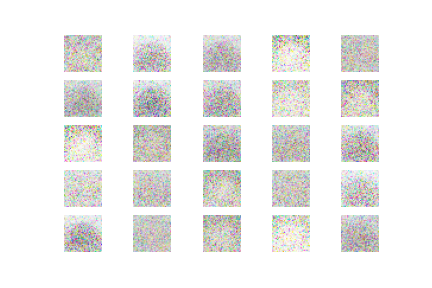 **<font color='red'>D loss: `0.692664`</font>, <font color='blue'>acc.: `46.88%`</font>, <font color='green'>G loss: `0.775617`</font>**|(probably) improve the quality of the generated samples|
|12. Change the `binary_crossentropy` loss to the L2 loss|What we are doing with the discriminator is trying to classify the fake and real data generated from the generator. So this is a classification task. So probability should be put in consideration. And the loss as well. MSE/L2 loss would be used more in case of task that needs regressions. I think even when we have some kinds of better results (in losses and accuracies), this change doesn't help the representation at all. At least, I hope it wouldn't worsen the quality of the generated samples.|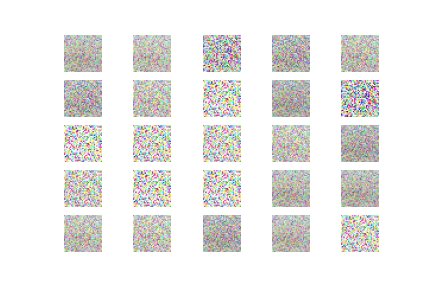 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|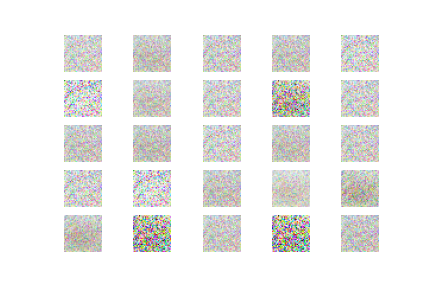 **<font color='red'>D loss: `0.262141`</font>, <font color='blue'>acc.: `43.75%`</font>, <font color='green'>G loss: `0.275556`</font>** |(seemingly) disminish the quality of the generated samples|
|13. Add more layers for a deeper network, 2 layers more for the generator, and 1 more for the discriminator|My own experience with deeper network was quite bad. Whenever I tried a normal model of NN with more layers, the outputs become worse and worse. So if I have to say, I don't have trust that the quality of samples would be better, just hope it won't get disminished.|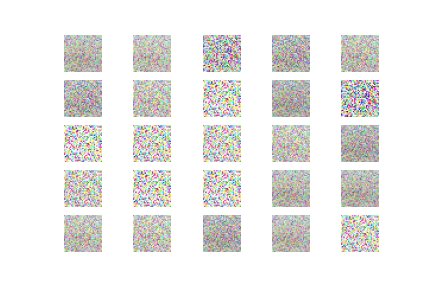 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**|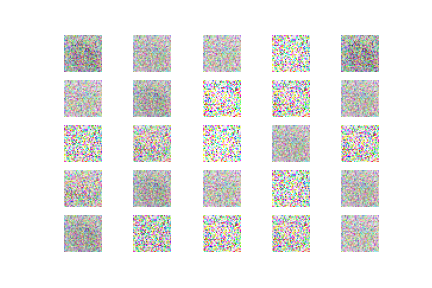 **<font color='red'>D loss: `0.759966`</font>, <font color='blue'>acc.: `3.12%`</font>, <font color='green'>G loss: `0.734740`</font>**|(well, it has no impact at all, it is like the original result with bolder tone) have no impact where it is unclear if it would improve the quality of the generated samples or not|
|14. Exchange the dense layers with convolutional ones.|In many papers, it's already shown that how CNN performed better over normal MLP model. So I bet this one will improve the quality of the generated samples.|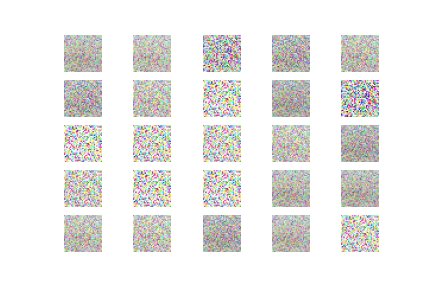 **<font color='red'>D loss: `0.742246`</font>, <font color='blue'>acc.: `9.38%`</font>, <font color='green'>G loss: `0.709937`</font>**| not checked (hope someone would)|(hopefully) improve the quality of the generated samples |




**Interesting things**: I made a big mistake!! I should have checked that the learning rate are absolutely so low and that was the main reason why most of the cases that should improve the quality turns into noises. So let's move on to the second run. I called it **second version** and the original source code in this case will be the **case 8** (which seems to generate nice blur images). We'll see what might come then!